# Solana prediction

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sol-historical-data/SOL-USD.csv


In [2]:
import os
import numpy as np 
import pandas as pd 
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, SimpleRNN

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
dataset = pd.read_csv('/kaggle/input/sol-historical-data/SOL-USD.csv')

In [4]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-10,0.832005,1.313487,0.694187,0.951054,0.951054,87364276.0
1,2020-04-11,0.951054,1.049073,0.765020,0.776819,0.776819,43862444.0
2,2020-04-12,0.785448,0.956670,0.762426,0.882507,0.882507,38736897.0
3,2020-04-13,0.890760,0.891603,0.773976,0.777832,0.777832,18211285.0
4,2020-04-14,0.777832,0.796472,0.628169,0.661925,0.661925,16747614.0


In [5]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1145,2023-05-30,20.587137,21.381718,20.519501,21.254084,21.254084,367512387.0
1146,2023-05-31,21.255285,21.318878,20.468752,20.824503,20.824503,246152341.0
1147,2023-06-01,20.824892,20.972609,20.464470,20.502218,20.502218,209047110.0
1148,2023-06-02,NaN,NaN,NaN,NaN,NaN,NaN
1149,2023-06-03,21.274784,21.301369,21.239672,21.240511,21.240511,230614624.0


In [6]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1.149000e+03
mean,47.080754,49.284838,44.834747,47.074487,47.074487,1.049443e+09
std,57.721843,60.189328,54.981287,57.656821,57.656821,1.408045e+09
min,0.513391,0.559759,0.505194,0.515273,0.515273,6.520200e+05
25%,3.837682,4.147920,3.639386,3.834676,3.834676,6.336138e+07
50%,26.254124,27.696987,24.498320,26.370008,26.370008,5.557310e+08
75%,46.903976,50.577522,44.076366,47.179443,47.179443,1.522024e+09
max,258.781555,260.062103,246.122421,258.934326,258.934326,1.706864e+10


In [7]:
dataset.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [8]:
dataset = dataset.dropna() 

## OHLC

In [9]:
import plotly.graph_objects as go
from datetime import datetime

In [10]:
fig = go.Figure(data=[go.Candlestick(x=dataset['Date'][500:],
                open=dataset['Open'][500:],
                high=dataset['High'][500:],
                low=dataset['Low'][500:],
                close=dataset['Adj Close'][500:])])

fig.show()

In [11]:
dataset['Adj Close'].dtype

dtype('float64')

## ADF and KPSS Test

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dataset['Adj Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.7441687885782
p-value: 0.4085109714923078
Critial Values:
   1%, -3.4361708439503587
Critial Values:
   5%, -2.86411024137968
Critial Values:
   10%, -2.5681384677365924


In [14]:
from numpy import log

result = adfuller(log(dataset['Adj Close'].values), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.9329579891130546
p-value: 0.31671895485076934
Critial Values:
   1%, -3.436064032324827
Critial Values:
   5%, -2.864063122757945
Critial Values:
   10%, -2.5681133731450605


## KPSS Test

In [15]:
from statsmodels.tsa.stattools import kpss

result = kpss(dataset['Adj Close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');


KPSS Statistic: 1.091674
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




## Autocorrelation Function (ACF)

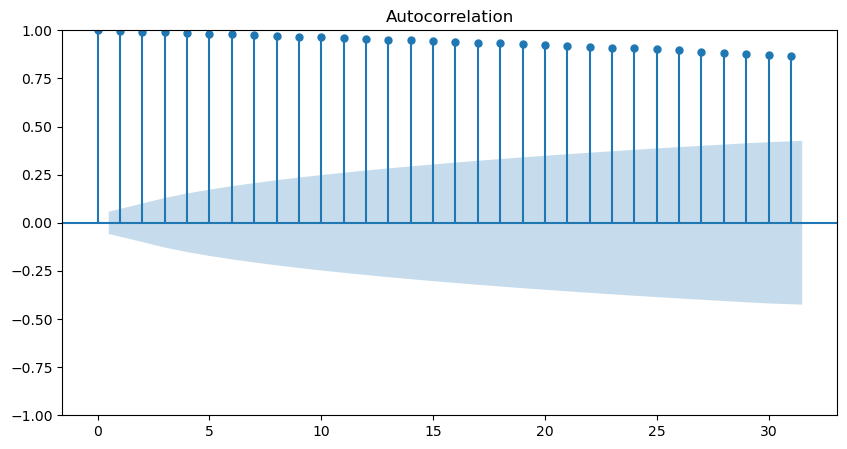

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf

plt.rc("figure", figsize=(10,5))
plot_acf(dataset['Adj Close'])
print()

## Partial Autocorrelation Function (PACF)

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



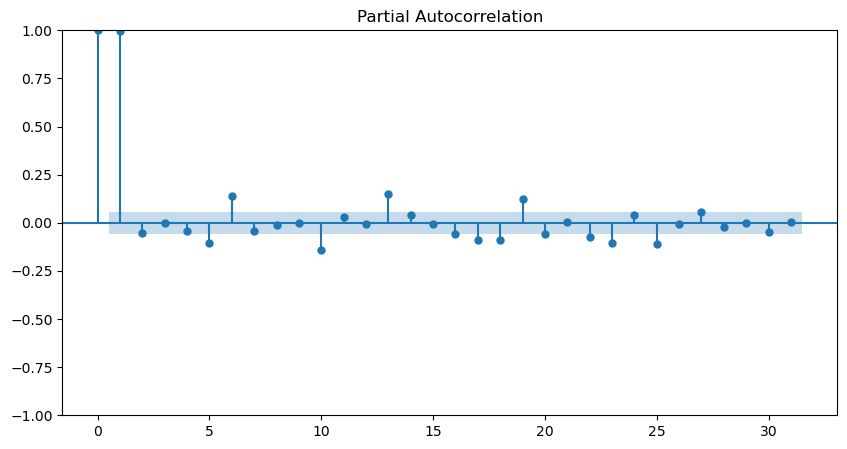

In [17]:
plt.rc("figure", figsize=(10,5))
plot_pacf(dataset['Adj Close'])
print()

## Price Forecasting

## Adj Close price

In [18]:
data = dataset['Adj Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (1149,)


## Train and Test data

In [19]:
# train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  919
Shape of Train and Test data:  (919,) (230,)


## Change Shape

In [20]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (919, 1) (230, 1)


## Split

In [21]:
def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        b = dataset[i+lookback, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

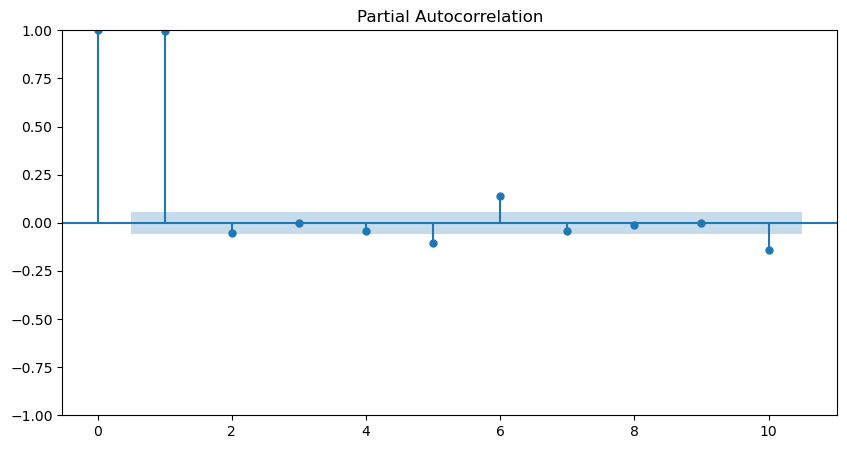

In [22]:
plot_pacf(data, lags=10)
plt.show()

In [23]:
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


In [24]:
train_X, train_y = create_dataset(train_data, lag)
test_X, test_y = create_dataset(test_data, lag)

In [25]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (916, 2) (916,)
Shape of test_X and test_y:  (227, 2) (227,)


In [26]:
print(train_data[:20])           
for x in range(len(train_X[:20])):
    print(test_X[x], test_y[x], )          

[[0.951054]
 [0.776819]
 [0.882507]
 [0.777832]
 [0.661925]
 [0.646651]
 [0.690816]
 [0.660728]
 [0.681096]
 [0.606969]
 [0.538812]
 [0.587659]
 [0.691601]
 [0.627457]
 [0.634242]
 [0.643329]
 [0.635506]
 [0.572372]
 [0.661293]
 [0.74584 ]]
[30.16884  31.224876] 30.164331
[31.224876 30.164331] 28.900799
[30.164331 28.900799] 28.085096
[28.900799 28.085096] 28.108677
[28.085096 28.108677] 28.013863
[28.108677 28.013863] 29.270071
[28.013863 29.270071] 28.310064
[29.270071 28.310064] 30.939976
[28.310064 30.939976] 31.284721
[30.939976 31.284721] 30.630625
[31.284721 30.630625] 32.111263
[30.630625 32.111263] 32.857128
[32.111263 32.857128] 32.965931
[32.857128 32.965931] 32.611038
[32.965931 32.611038] 32.248425
[32.611038 32.248425] 30.788076
[32.248425 30.788076] 30.84388
[30.788076 30.84388 ] 33.780853
[30.84388  33.780853] 36.765762
[33.780853 36.765762] 32.683582


In [27]:
np.random.seed(7)

In [28]:
model = Sequential()
model.add(Dense(64, input_dim = lag, activation='relu', name= "1st_hidden"))
# model.add(Dense(64, activation='relu', name = '2nd_hidden'))
model.add(Dense(1, name = 'Output_layer', activation='linear'))
# model.add(Activation("linear", name = 'Linear_activation'))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden (Dense)          (None, 64)                192       
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [29]:
epoch_number = 100
batches = 64
history = model.fit(train_X, train_y, epochs = epoch_number, batch_size = batches, verbose = 1, shuffle=False, 
                    validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 1s 20ms/step - loss: 5025.8135 - val_loss: 801.3427
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 3831.2334 - val_loss: 601.1248
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 2818.2258 - val_loss: 432.1993
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 2001.3492 - val_loss: 299.7229
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 1360.7196 - val_loss: 195.6736
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 865.2964 - val_loss: 117.5064
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 504.6358 - val_loss: 63.0662
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 264.0412 - val_loss: 28.5792
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 125.1453 - val_loss: 11.2057
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - lo

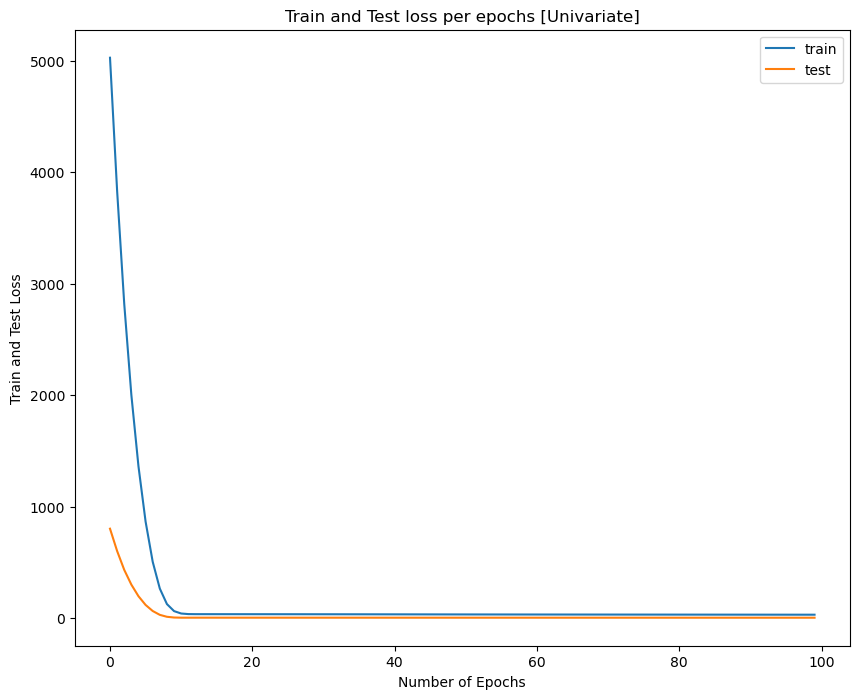

In [30]:
plt.clf
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Number of Epochs')
plt.ylabel('Train and Test Loss')
plt.title('Train and Test loss per epochs [Univariate]')
plt.legend()
plt.show()

## Prediction

In [31]:
testPredict = model.predict(test_X)

8/8 [==============================] - 0s 1ms/step


In [32]:
testPredict[:10]

array([[31.107412],
       [30.81725 ],
       [29.633226],
       [28.65956 ],
       [28.379581],
       [28.32803 ],
       [29.089695],
       [28.935612],
       [30.254694],
       [31.424133]], dtype=float32)

## Model evaluation

In [33]:
testScore = math.sqrt(mean_squared_error(test_y[:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 1.51 RMSE


## Actual Test data and Predicted Data

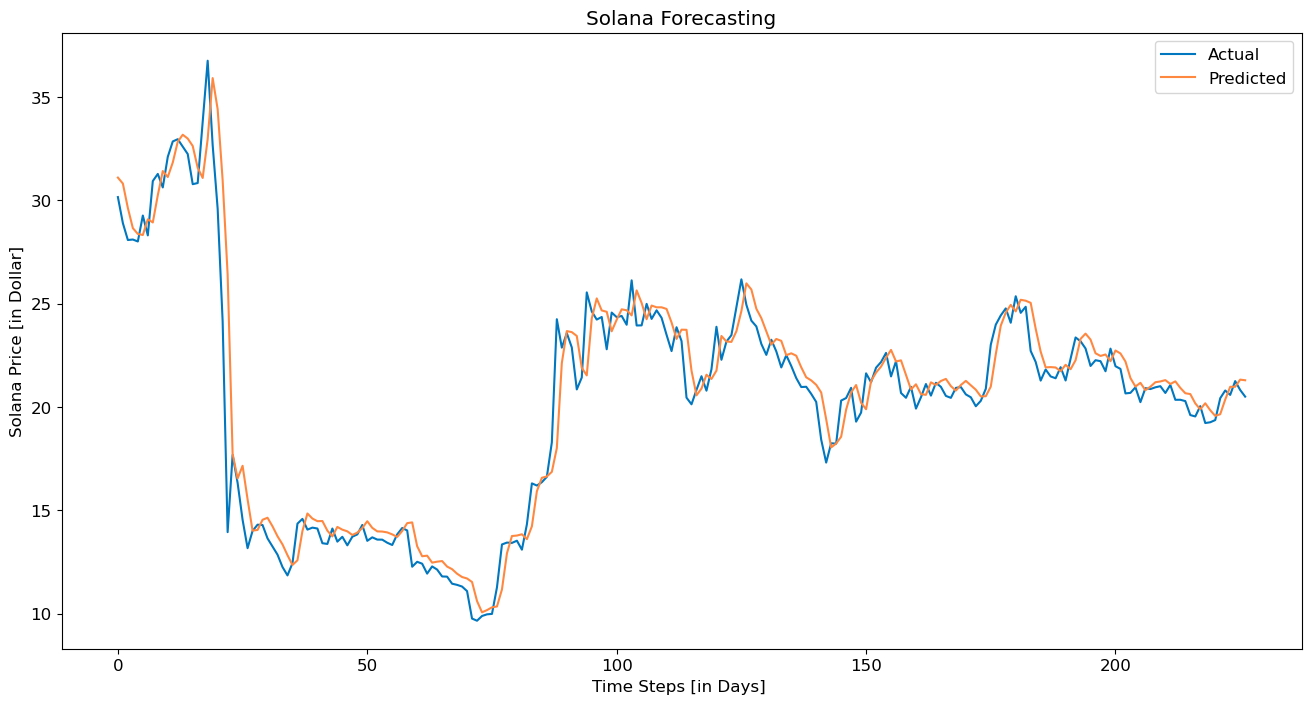

In [34]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 12})
plt.plot(test_y[:], '#0077be',label = 'Actual')
plt.plot(testPredict[:,0], '#ff8841',label = 'Predicted')
plt.title('Solana Forecasting')
plt.ylabel('Solana Price [in Dollar]')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()

## RNN - Recurrent Neural Network

## "Adj Close" price

In [35]:
data = dataset['Adj Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (1149,)


In [36]:
# train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  919
Shape of Train and Test data:  919 230


In [37]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [38]:
lag = 2 
n_features = 1

In [39]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [40]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (917, 2) (917,)
Shape of test_X and test_y:  (228, 2) (228,)


##  Reshape train_X and test_X

In [41]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [42]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (917, 2, 1) (917,)
Shape of test_X and test_y:  (228, 2, 1) (228,)


In [43]:
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences=False, input_shape=(lag, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [44]:
tf.config.run_functions_eagerly(True)

In [45]:
history = model.fit(train_X, train_y, epochs = 50, batch_size=64, verbose=1, validation_split= 0.1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



13/13 [==============================] - 1s 42ms/step - loss: 5066.2520 - val_loss: 394.6026
Epoch 2/50
13/13 [==============================] - 0s 38ms/step - loss: 977.6539 - val_loss: 27.3657
Epoch 3/50
13/13 [==============================] - 1s 39ms/step - loss: 85.4738 - val_loss: 17.3089
Epoch 4/50
13/13 [==============================] - 1s 40ms/step - loss: 93.7397 - val_loss: 6.4820
Epoch 5/50
13/13 [==============================] - 0s 38ms/step - loss: 37.4548 - val_loss: 3.0855
Epoch 6/50
13/13 [==============================] - 0s 38ms/step - loss: 37.4677 - val_loss: 3.1777
Epoch 7/50
13/13 [==============================] - 0s 37ms/step - loss: 35.3034 - val_loss: 3.1222
Epoch 8/50
13/13 [==============================] - 0s 38ms/step - loss: 35.4210 - val_loss: 3.1926
Epoch 9/50
13/13 [==============================] - 0s 37ms/step - loss: 34.9420 - val_loss: 3.0817
Epoch 10/50
13/13 [==============================] - 0s 38ms/step - loss: 35.4688 - val_loss: 3.0506
Epo

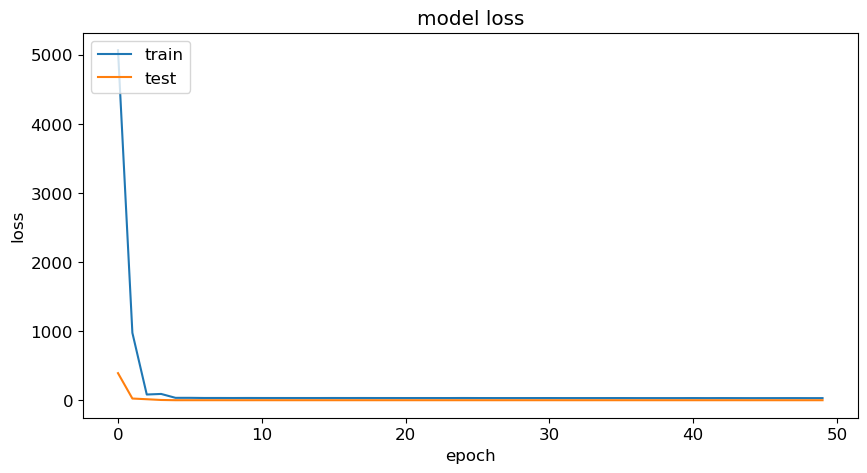

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)
print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

8/8 [==============================] - 0s 11ms/step
Shape of train and test predict:  (917, 1) (228, 1)


In [48]:
def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(train_y, train_predict)
test_score = measure_rmse(test_y, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  5.471815334330413 1.5616400742563221


## Predicted data

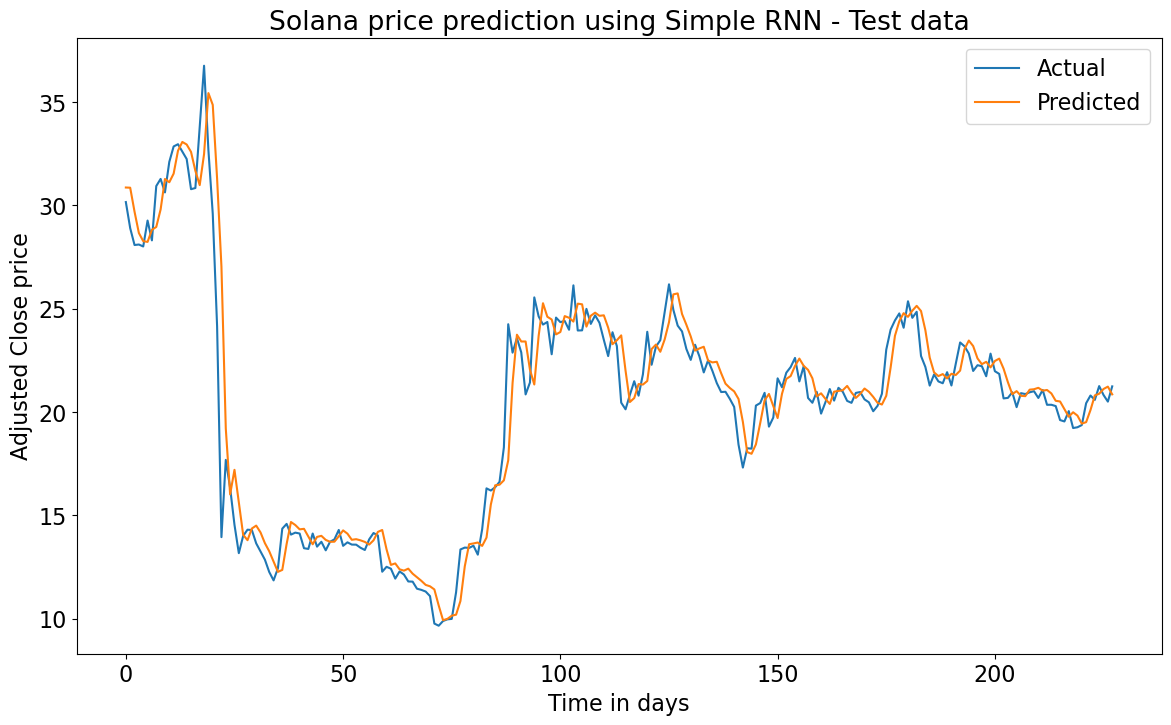

In [49]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Adjusted Close price')
plt.title('Solana price prediction using Simple RNN - Test data')
plt.legend()
plt.show()